## 8.
_연습문제: 정책 그레이디언트를 사용해 OpenAI 짐의 LunarLander-v2 환경을 해결해보세요. 이를 위해 Box2D 패키지를 설치해야 합니다(`%pip install -U gym[box2d]`)._

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # do not use gpu

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install -U gym[box2d]

     |████████████████████████████████| 734 kB 9.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 18.3 MB 12.9 MB/s eta 0:00:011
     |████████████████████████████████| 3.7 MB 19.7 MB/s eta 0:00:01
     |████████████████████████████████| 374 kB 36.4 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /home/dongho/anaconda3/envs/HOML/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-y_59ks1_/box2d-py_4a0d6b32f63e4bc0a5c4cc7a46ee6480/setup.py'"'"'; __file__='"'"'/tmp/pip-install-y_59ks1_/box2d-py_4a0d6b32f63e4bc0a5c4cc7a46ee6480/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"

In [4]:
import gym
env = gym.make("LunarLander-v2")

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
obs = env.reset()
print(obs)

[ 0.00466375  1.4152391   0.472367    0.19194697 -0.00539729 -0.10699828
  0.          0.        ]


In [6]:
env.action_space

Discrete(4)

### Q-network

In [9]:
n_inputs = env.observation_space.shape[0] # observation's space to fit in the net
n_outputs = env.action_space.n # env's input shape-> which is the action we take

In [10]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax") # pick one
])

2022-08-20 12:06:06.006962: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-20 12:06:06.006999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: debian
2022-08-20 12:06:06.007007: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: debian
2022-08-20 12:06:06.007098: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-08-20 12:06:06.007124: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-08-20 12:06:06.007131: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-08-20 12:06:06.007512: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

그다음 CartPole-v1 정책 그레이디언트 코드에서 정의한 `play_one_step()`와 `play_multiple_episodes()` 함수를 재사용합니다. 하지만 다중 분류 모델에 맞게 `play_one_step()`를 조금 수정하겠습니다. 그다음 수정된 `play_one_step()` 를 호출하고, 우주선이 최대 스텝 횟수 전에 랜딩하지 못하면 (또는 부서지면) 큰 페널티를 부여하도록 `play_multiple_episodes()` 함수를 수정합니다.

In [11]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas+keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1) # this picks out the
        #action we would take based on probabilities
        loss = tf.reduce_mean(loss_fn(action, probas)) # goal is to make the action more likely
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info= env.step(action[0,0].numpy())
    return obs, reward, done, grads

In [12]:
def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        
        for step in range(n_max_steps):
            obs, reward, done, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

앞에서와 동일한 discount_rewards()와 discount_and_normalize_rewards() 함수를 사용합니다:

In [13]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards) # one vector
    for step in range(len(rewards) -2, -1, -1):
        discounted[step] += discount_rate * discounted[step + 1]
    return discounted

In [18]:
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [15]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99

여기서도 다중 분류 모델이기 때문에 이진 크로스 엔트로피가 아니라 범주형 크로스 엔트로피를 사용해야 합니다. 또한 `lander_play_one_step()` 함수가 클래스 확률이 아니라 클래스 레이블로 타깃을 설정하기 때문에 `sparse_categorical_crossentropy()` 손실 함수를 사용해야 합니다:

In [16]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [19]:
env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    
    print("\rIteration: {}/{}, mean reward: {:.1f}".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 200/200, mean reward: 131.7

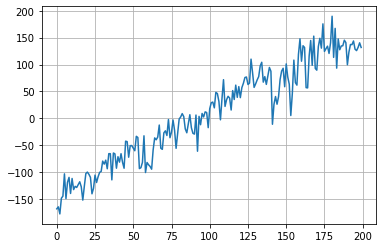

In [20]:
plt.plot(mean_rewards)
plt.grid()
plt.show()

In [21]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v2")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0,0].numpy())
        if done:
            break
    env.close()
    return frames

In [38]:
frames = lander_render_policy_net(model, seed=42)

In [39]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [40]:
import PIL

image_path = os.path.join("images", "LunarLander.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:250]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [37]:
%%html
<img src="images/LunarLander.gif" />

## 9.
_연습문제: 알고리즘에 상관없이 TF-Agents를 사용해 SpaceInvaders-v4 환경에서 사람을 능가하는 에이전트를 훈련해보세요._

`"Breakout-v4"`를 `"SpaceInvaders-v4"`로 바꾸고 [TF Agents를 사용해 브레이크아웃 게임하기](#TF-Agents%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%B4-%EB%B8%8C%EB%A0%88%EC%9D%B4%ED%81%AC%EC%95%84%EC%9B%83-%EA%B2%8C%EC%9E%84%ED%95%98%EA%B8%B0) 절에 있는 단계를 따라해 보세요. 하지만 몇 가지를 바꾸어야 합니다. 예를 들어 스페이스 인베이더 게임은 게임을 시작할 때 FIRE 버튼을 누를 필요가 없습니다. 대신 플레이어의 레이저 캐논이 몇 초간 깜빡거린 다음 자동으로 게임이 시작됩니다. 성능을 높이려면 에피소드를 시작할 때와 죽을 때마다 깜빡임 단계(약 40 스텝 동안 지속됩니다)를 건너 뛸 수 있습니다. 사실 이 단계에서는 아무것도 할 수 없고 아무것도 움직이지 않습니다. 건너 뛰는 방법은 `AtariPreprocessingWithAutoFire` 래퍼 대신에 다음과 같은 사용자 정의 환경 래퍼를 사용하는 것입니다:

In [2]:
from tf_agents.environments import suite_gym

env = suite_gym.load("SpaceInvaders-v4")

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8),
 'reward': array(0., dtype

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


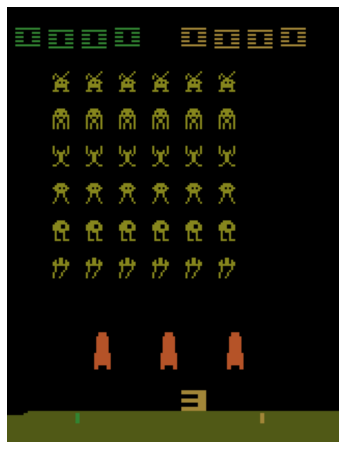

In [4]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [6]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)

In [7]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

In [8]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000
environment_name = "SpaceInvadersNoFrameskip-v4"

class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
            super().step(0) # do nothing
    
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self.skip_frames(40) # do nothing for 40 frames on startup
        return obs
    
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action) # super() is the same thing as env!
        if self.ale.lives() < lives_before_action and not done: # just died-> skip_frames
            self.skip_frames(40)
        return obs, rewards, done, info
        
    

In [9]:
env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithSkipStart, FrameStack4])

In [10]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

In [11]:
# Q-network
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 255.)

conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]

q_net = QNetwork(
    tf_env.observation_spec(), ## put in specs for input and output of the model!
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params = fc_layer_params,
)

In [12]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0,
                                     epsilon=0.00001, centered=True)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial epsilon
    decay_steps = 250000 // update_period,
    end_learning_rate=0.01)

agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(), # no need for obs spec!
    q_network = q_net,
    optimizer = optimizer,
    target_update_period=2000, # time to update the target from online model
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),# loss function
    gamma = 0.99,
    train_step_counter=train_step,
    epsilon_greedy = lambda: epsilon_fn(train_step)
)

agent.initialize()

2022-08-21 03:21:01.350089: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-21 03:21:01.350123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: debian
2022-08-21 03:21:01.350131: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: debian
2022-08-21 03:21:01.350211: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-08-21 03:21:01.350236: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-08-21 03:21:01.350243: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-08-21 03:21:01.350687: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

In [13]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size = tf_env.batch_size,
    max_length = 500000)

replay_buffer_observer = replay_buffer.add_batch # a function to put data in to buffer
    

2022-08-21 03:21:04.302076: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 14112000000 exceeds 10% of free system memory.


In [14]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
        
    def __call__(self, trajectory):
        if not trajectory.is_boundary(): # inside of play
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [15]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [16]:
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)


INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [17]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env, 
    agent.collect_policy,
    observers = [replay_buffer_observer] + train_metrics,
    num_steps=update_period)


In [18]:
# get experiences before training
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000)

final_time_step, final_policy_state = init_driver.run()

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


20000/20000

In [19]:
trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [20]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [21]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [22]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
print(time_steps.observation.shape)

(2, 2, 84, 84, 4)


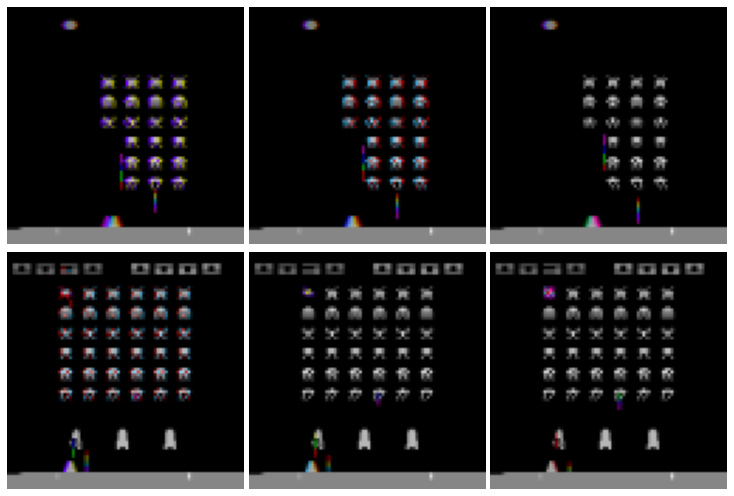

In [25]:
def plot_observation(obs):
    # 컬러 채널이 3개이기 때문에 4 프레임을 출력할 수 없습니다.
    # 따라서 현재 프레임과 다른 프레임의 평균 값을 뺀 차이를 계산합니다.
    # 그다음 이 차이를 현재 프레임의 빨강과 파랑 채널에 더해서 보라 색을 구합니다.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
plt.show()

In [26]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3
).prefetch(3)

In [27]:
from tf_agents.utils.common import function
collect_driver.run = function(collect_driver.run) # turn it into tf-function to increase performance
agent.train = function(agent.train)

In [28]:
from time import time


def train_agent(n_iterations):
    start_time = time()
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset) # iterator 객채
    for iteration in range(n_iterations): 
        time_step, policy_state = collect_driver.run(time_step, policy_state) # 탐색 
        trajectories, buffer_info = next(iterator) # 가져옴
        train_loss = agent.train(trajectories) # 훈련
        print("\r{} loss:{:.5f}".format( iteration, train_loss.loss.numpy()), end="")
        
        if iteration % 1000 == 0:
            print()
            print("elapsed_time: {:.2f}s".format(time()-start_time))
            start_time = time()
            log_metrics(train_metrics) # log values

In [35]:
### doing this trains the algorism
train_agent(500000)

INFO:absl: 
		 NumberOfEpisodes = 3554
		 EnvironmentSteps = 2294476
		 AverageReturn = 529.5
		 AverageEpisodeLength = 822.9000244140625


0 loss:1.21611
elapsed_time: 0.11s
997 loss:0.71152

INFO:absl: 
		 NumberOfEpisodes = 3559
		 EnvironmentSteps = 2298476
		 AverageReturn = 611.0
		 AverageEpisodeLength = 940.5999755859375


1000 loss:1.15416
elapsed_time: 40.27s
1997 loss:1.10308

INFO:absl: 
		 NumberOfEpisodes = 3563
		 EnvironmentSteps = 2302476
		 AverageReturn = 658.0
		 AverageEpisodeLength = 982.5999755859375


2000 loss:1.59718
elapsed_time: 41.05s
2995 loss:1.25441

INFO:absl: 
		 NumberOfEpisodes = 3568
		 EnvironmentSteps = 2306476
		 AverageReturn = 608.0
		 AverageEpisodeLength = 873.7000122070312


3000 loss:0.97912
elapsed_time: 41.35s
3998 loss:1.00749

INFO:absl: 
		 NumberOfEpisodes = 3573
		 EnvironmentSteps = 2310476
		 AverageReturn = 525.5
		 AverageEpisodeLength = 815.5999755859375


4000 loss:0.99973
elapsed_time: 41.37s
4995 loss:2.15251

INFO:absl: 
		 NumberOfEpisodes = 3577
		 EnvironmentSteps = 2314476
		 AverageReturn = 453.5
		 AverageEpisodeLength = 791.0


5000 loss:0.84574
elapsed_time: 41.35s
5995 loss:0.74649

INFO:absl: 
		 NumberOfEpisodes = 3581
		 EnvironmentSteps = 2318476
		 AverageReturn = 544.5
		 AverageEpisodeLength = 820.9000244140625


6000 loss:1.42487
elapsed_time: 41.17s
6999 loss:0.97968

INFO:absl: 
		 NumberOfEpisodes = 3585
		 EnvironmentSteps = 2322476
		 AverageReturn = 684.5
		 AverageEpisodeLength = 1009.4000244140625


7000 loss:1.89950
elapsed_time: 41.51s
7997 loss:0.77006

INFO:absl: 
		 NumberOfEpisodes = 3588
		 EnvironmentSteps = 2326476
		 AverageReturn = 801.5
		 AverageEpisodeLength = 1069.300048828125


8000 loss:1.24062
elapsed_time: 40.83s
8998 loss:1.18771

INFO:absl: 
		 NumberOfEpisodes = 3593
		 EnvironmentSteps = 2330476
		 AverageReturn = 770.5
		 AverageEpisodeLength = 1071.5999755859375


9000 loss:1.88325
elapsed_time: 41.27s
9997 loss:1.57595

INFO:absl: 
		 NumberOfEpisodes = 3597
		 EnvironmentSteps = 2334476
		 AverageReturn = 662.5
		 AverageEpisodeLength = 936.2000122070312


10000 loss:3.03193
elapsed_time: 41.22s
10996 loss:0.95865

INFO:absl: 
		 NumberOfEpisodes = 3601
		 EnvironmentSteps = 2338476
		 AverageReturn = 603.0
		 AverageEpisodeLength = 893.2999877929688


11000 loss:1.61442
elapsed_time: 41.20s
11996 loss:0.92480

INFO:absl: 
		 NumberOfEpisodes = 3606
		 EnvironmentSteps = 2342476
		 AverageReturn = 565.0
		 AverageEpisodeLength = 882.0


12000 loss:2.37378
elapsed_time: 41.36s
12997 loss:0.84582

INFO:absl: 
		 NumberOfEpisodes = 3611
		 EnvironmentSteps = 2346476
		 AverageReturn = 555.0
		 AverageEpisodeLength = 789.2999877929688


13000 loss:1.31473
elapsed_time: 41.40s
13998 loss:2.21792

INFO:absl: 
		 NumberOfEpisodes = 3616
		 EnvironmentSteps = 2350476
		 AverageReturn = 684.0
		 AverageEpisodeLength = 876.4000244140625


14000 loss:0.90357
elapsed_time: 41.22s
14999 loss:2.56676

INFO:absl: 
		 NumberOfEpisodes = 3621
		 EnvironmentSteps = 2354476
		 AverageReturn = 628.0
		 AverageEpisodeLength = 807.0


15000 loss:1.16765
elapsed_time: 41.36s
15995 loss:1.90742

INFO:absl: 
		 NumberOfEpisodes = 3625
		 EnvironmentSteps = 2358476
		 AverageReturn = 597.0
		 AverageEpisodeLength = 854.7000122070312


16000 loss:0.92300
elapsed_time: 41.15s
16996 loss:0.86782

INFO:absl: 
		 NumberOfEpisodes = 3629
		 EnvironmentSteps = 2362476
		 AverageReturn = 666.5
		 AverageEpisodeLength = 987.0999755859375


17000 loss:1.11252
elapsed_time: 41.22s
17996 loss:1.33576

INFO:absl: 
		 NumberOfEpisodes = 3634
		 EnvironmentSteps = 2366476
		 AverageReturn = 724.0
		 AverageEpisodeLength = 963.7999877929688


18000 loss:1.29233
elapsed_time: 41.62s
18999 loss:1.04812

INFO:absl: 
		 NumberOfEpisodes = 3638
		 EnvironmentSteps = 2370476
		 AverageReturn = 697.0
		 AverageEpisodeLength = 944.4000244140625


19000 loss:1.10226
elapsed_time: 41.26s
19996 loss:1.17416

INFO:absl: 
		 NumberOfEpisodes = 3641
		 EnvironmentSteps = 2374476
		 AverageReturn = 820.5
		 AverageEpisodeLength = 1089.4000244140625


20000 loss:1.29420
elapsed_time: 41.25s
20998 loss:1.57677

INFO:absl: 
		 NumberOfEpisodes = 3645
		 EnvironmentSteps = 2378476
		 AverageReturn = 805.5
		 AverageEpisodeLength = 1037.0


21000 loss:0.87398
elapsed_time: 41.31s
21996 loss:4.12470

INFO:absl: 
		 NumberOfEpisodes = 3650
		 EnvironmentSteps = 2382476
		 AverageReturn = 663.5
		 AverageEpisodeLength = 882.9000244140625


22000 loss:1.72854
elapsed_time: 41.40s
22995 loss:0.76070

INFO:absl: 
		 NumberOfEpisodes = 3655
		 EnvironmentSteps = 2386476
		 AverageReturn = 587.0
		 AverageEpisodeLength = 825.4000244140625


23000 loss:0.86177
elapsed_time: 41.41s
23997 loss:1.34129

INFO:absl: 
		 NumberOfEpisodes = 3659
		 EnvironmentSteps = 2390476
		 AverageReturn = 610.0
		 AverageEpisodeLength = 839.7000122070312


24000 loss:1.27525
elapsed_time: 41.19s
24999 loss:0.90513

INFO:absl: 
		 NumberOfEpisodes = 3664
		 EnvironmentSteps = 2394476
		 AverageReturn = 661.5
		 AverageEpisodeLength = 898.0999755859375


25000 loss:1.35284
elapsed_time: 41.22s
25995 loss:1.06773

INFO:absl: 
		 NumberOfEpisodes = 3669
		 EnvironmentSteps = 2398476
		 AverageReturn = 617.5
		 AverageEpisodeLength = 870.4000244140625


26000 loss:0.48435
elapsed_time: 41.34s
26999 loss:1.10687

INFO:absl: 
		 NumberOfEpisodes = 3672
		 EnvironmentSteps = 2402476
		 AverageReturn = 598.5
		 AverageEpisodeLength = 893.5


27000 loss:1.02824
elapsed_time: 41.16s
27997 loss:0.98605

INFO:absl: 
		 NumberOfEpisodes = 3678
		 EnvironmentSteps = 2406476
		 AverageReturn = 623.0
		 AverageEpisodeLength = 836.7999877929688


28000 loss:1.05646
elapsed_time: 41.22s
28996 loss:1.02992

INFO:absl: 
		 NumberOfEpisodes = 3681
		 EnvironmentSteps = 2410476
		 AverageReturn = 705.5
		 AverageEpisodeLength = 992.7000122070312


29000 loss:1.86538
elapsed_time: 41.15s
29995 loss:0.67921

INFO:absl: 
		 NumberOfEpisodes = 3686
		 EnvironmentSteps = 2414476
		 AverageReturn = 626.0
		 AverageEpisodeLength = 901.5999755859375


30000 loss:1.11117
elapsed_time: 41.30s
30999 loss:1.14096

INFO:absl: 
		 NumberOfEpisodes = 3692
		 EnvironmentSteps = 2418476
		 AverageReturn = 551.5
		 AverageEpisodeLength = 695.9000244140625


31000 loss:0.92236
elapsed_time: 41.36s
31996 loss:0.92921

INFO:absl: 
		 NumberOfEpisodes = 3696
		 EnvironmentSteps = 2422476
		 AverageReturn = 597.0
		 AverageEpisodeLength = 756.9000244140625


32000 loss:1.12640
elapsed_time: 41.27s
32999 loss:1.43271

INFO:absl: 
		 NumberOfEpisodes = 3701
		 EnvironmentSteps = 2426476
		 AverageReturn = 621.5
		 AverageEpisodeLength = 863.4000244140625


33000 loss:0.71645
elapsed_time: 41.28s
33997 loss:1.15841

INFO:absl: 
		 NumberOfEpisodes = 3706
		 EnvironmentSteps = 2430476
		 AverageReturn = 568.0
		 AverageEpisodeLength = 804.5999755859375


34000 loss:0.66095
elapsed_time: 41.38s
34999 loss:0.85844

INFO:absl: 
		 NumberOfEpisodes = 3710
		 EnvironmentSteps = 2434476
		 AverageReturn = 551.0
		 AverageEpisodeLength = 821.5


35000 loss:1.31986
elapsed_time: 41.17s
35995 loss:1.72595

INFO:absl: 
		 NumberOfEpisodes = 3715
		 EnvironmentSteps = 2438476
		 AverageReturn = 510.5
		 AverageEpisodeLength = 797.5999755859375


36000 loss:0.97024
elapsed_time: 41.28s
36999 loss:1.12908

INFO:absl: 
		 NumberOfEpisodes = 3720
		 EnvironmentSteps = 2442476
		 AverageReturn = 561.5
		 AverageEpisodeLength = 874.7999877929688


37000 loss:1.53254
elapsed_time: 41.26s
37998 loss:1.06530

INFO:absl: 
		 NumberOfEpisodes = 3725
		 EnvironmentSteps = 2446476
		 AverageReturn = 594.0
		 AverageEpisodeLength = 824.0


38000 loss:1.61436
elapsed_time: 41.39s
38998 loss:0.97392

INFO:absl: 
		 NumberOfEpisodes = 3729
		 EnvironmentSteps = 2450476
		 AverageReturn = 554.0
		 AverageEpisodeLength = 831.2000122070312


39000 loss:1.59737
elapsed_time: 41.30s
39998 loss:1.78492

INFO:absl: 
		 NumberOfEpisodes = 3736
		 EnvironmentSteps = 2454476
		 AverageReturn = 502.0
		 AverageEpisodeLength = 778.2000122070312


40000 loss:0.72550
elapsed_time: 41.45s
40998 loss:0.79517

INFO:absl: 
		 NumberOfEpisodes = 3740
		 EnvironmentSteps = 2458476
		 AverageReturn = 520.0
		 AverageEpisodeLength = 727.2999877929688


41000 loss:1.93437
elapsed_time: 41.28s
41996 loss:1.17549

INFO:absl: 
		 NumberOfEpisodes = 3745
		 EnvironmentSteps = 2462476
		 AverageReturn = 532.0
		 AverageEpisodeLength = 759.2000122070312


42000 loss:1.56859
elapsed_time: 41.48s
42995 loss:1.53995

INFO:absl: 
		 NumberOfEpisodes = 3751
		 EnvironmentSteps = 2466476
		 AverageReturn = 546.0
		 AverageEpisodeLength = 726.5999755859375


43000 loss:1.02639
elapsed_time: 41.53s
43999 loss:1.54011

INFO:absl: 
		 NumberOfEpisodes = 3757
		 EnvironmentSteps = 2470476
		 AverageReturn = 584.0
		 AverageEpisodeLength = 728.5


44000 loss:3.78443
elapsed_time: 41.48s
44997 loss:1.20400

INFO:absl: 
		 NumberOfEpisodes = 3761
		 EnvironmentSteps = 2474476
		 AverageReturn = 618.5
		 AverageEpisodeLength = 813.7999877929688


45000 loss:0.73660
elapsed_time: 41.30s
45995 loss:1.18499

INFO:absl: 
		 NumberOfEpisodes = 3765
		 EnvironmentSteps = 2478476
		 AverageReturn = 622.5
		 AverageEpisodeLength = 831.0999755859375


46000 loss:0.96000
elapsed_time: 41.57s
46998 loss:1.36452

INFO:absl: 
		 NumberOfEpisodes = 3769
		 EnvironmentSteps = 2482476
		 AverageReturn = 621.0
		 AverageEpisodeLength = 895.7000122070312


47000 loss:1.73996
elapsed_time: 41.14s
47996 loss:1.12894

INFO:absl: 
		 NumberOfEpisodes = 3774
		 EnvironmentSteps = 2486476
		 AverageReturn = 618.5
		 AverageEpisodeLength = 920.7000122070312


48000 loss:1.19786
elapsed_time: 41.54s
48998 loss:1.71971

INFO:absl: 
		 NumberOfEpisodes = 3778
		 EnvironmentSteps = 2490476
		 AverageReturn = 673.5
		 AverageEpisodeLength = 953.4000244140625


49000 loss:1.60640
elapsed_time: 41.08s
49999 loss:1.03054

INFO:absl: 
		 NumberOfEpisodes = 3782
		 EnvironmentSteps = 2494476
		 AverageReturn = 630.0
		 AverageEpisodeLength = 868.9000244140625


50000 loss:1.33579
elapsed_time: 41.87s
50999 loss:0.72053

INFO:absl: 
		 NumberOfEpisodes = 3786
		 EnvironmentSteps = 2498476
		 AverageReturn = 638.0
		 AverageEpisodeLength = 961.5999755859375


51000 loss:0.94109
elapsed_time: 40.99s
51997 loss:0.91580

INFO:absl: 
		 NumberOfEpisodes = 3791
		 EnvironmentSteps = 2502476
		 AverageReturn = 692.0
		 AverageEpisodeLength = 993.2999877929688


52000 loss:2.72352
elapsed_time: 41.37s
52999 loss:0.85054

INFO:absl: 
		 NumberOfEpisodes = 3794
		 EnvironmentSteps = 2506476
		 AverageReturn = 701.0
		 AverageEpisodeLength = 1007.9000244140625


53000 loss:1.87335
elapsed_time: 41.08s
53998 loss:1.04969

INFO:absl: 
		 NumberOfEpisodes = 3798
		 EnvironmentSteps = 2510476
		 AverageReturn = 694.0
		 AverageEpisodeLength = 1033.9000244140625


54000 loss:1.06926
elapsed_time: 41.91s
54998 loss:0.91939

INFO:absl: 
		 NumberOfEpisodes = 3804
		 EnvironmentSteps = 2514476
		 AverageReturn = 582.5
		 AverageEpisodeLength = 847.2999877929688


55000 loss:1.29642
elapsed_time: 40.92s
55996 loss:1.56077

INFO:absl: 
		 NumberOfEpisodes = 3807
		 EnvironmentSteps = 2518476
		 AverageReturn = 617.0
		 AverageEpisodeLength = 874.0


56000 loss:1.23902
elapsed_time: 41.46s
56995 loss:1.26656

INFO:absl: 
		 NumberOfEpisodes = 3812
		 EnvironmentSteps = 2522476
		 AverageReturn = 576.5
		 AverageEpisodeLength = 859.7000122070312


57000 loss:1.23822
elapsed_time: 41.31s
57995 loss:1.87570

INFO:absl: 
		 NumberOfEpisodes = 3817
		 EnvironmentSteps = 2526476
		 AverageReturn = 594.0
		 AverageEpisodeLength = 847.7999877929688


58000 loss:1.15234
elapsed_time: 41.68s
58996 loss:1.16797

INFO:absl: 
		 NumberOfEpisodes = 3823
		 EnvironmentSteps = 2530476
		 AverageReturn = 630.0
		 AverageEpisodeLength = 763.5999755859375


59000 loss:0.91347
elapsed_time: 41.87s
59996 loss:0.89780

INFO:absl: 
		 NumberOfEpisodes = 3827
		 EnvironmentSteps = 2534476
		 AverageReturn = 642.0
		 AverageEpisodeLength = 790.0


60000 loss:0.66805
elapsed_time: 41.92s
60999 loss:1.09206

INFO:absl: 
		 NumberOfEpisodes = 3830
		 EnvironmentSteps = 2538476
		 AverageReturn = 645.0
		 AverageEpisodeLength = 959.5


61000 loss:1.28775
elapsed_time: 41.82s
61997 loss:0.98274

INFO:absl: 
		 NumberOfEpisodes = 3833
		 EnvironmentSteps = 2542476
		 AverageReturn = 711.5
		 AverageEpisodeLength = 1178.199951171875


62000 loss:1.59534
elapsed_time: 42.01s
62996 loss:0.93773

INFO:absl: 
		 NumberOfEpisodes = 3836
		 EnvironmentSteps = 2546476
		 AverageReturn = 748.0
		 AverageEpisodeLength = 1287.800048828125


63000 loss:0.91574
elapsed_time: 42.12s
63999 loss:1.01228

INFO:absl: 
		 NumberOfEpisodes = 3840
		 EnvironmentSteps = 2550476
		 AverageReturn = 766.0
		 AverageEpisodeLength = 1232.5


64000 loss:0.63803
elapsed_time: 42.05s
64997 loss:0.96652

INFO:absl: 
		 NumberOfEpisodes = 3846
		 EnvironmentSteps = 2554476
		 AverageReturn = 620.5
		 AverageEpisodeLength = 838.5


65000 loss:0.67045
elapsed_time: 42.10s
65999 loss:0.63564

INFO:absl: 
		 NumberOfEpisodes = 3851
		 EnvironmentSteps = 2558476
		 AverageReturn = 610.0
		 AverageEpisodeLength = 764.9000244140625


66000 loss:0.74781
elapsed_time: 42.12s
66997 loss:1.19397

INFO:absl: 
		 NumberOfEpisodes = 3855
		 EnvironmentSteps = 2562476
		 AverageReturn = 635.0
		 AverageEpisodeLength = 865.2000122070312


67000 loss:1.25558
elapsed_time: 42.18s
67999 loss:1.95825

INFO:absl: 
		 NumberOfEpisodes = 3859
		 EnvironmentSteps = 2566476
		 AverageReturn = 687.5
		 AverageEpisodeLength = 920.9000244140625


68000 loss:0.83124
elapsed_time: 42.17s
68996 loss:0.91531

INFO:absl: 
		 NumberOfEpisodes = 3864
		 EnvironmentSteps = 2570476
		 AverageReturn = 669.0
		 AverageEpisodeLength = 863.5999755859375


69000 loss:1.38564
elapsed_time: 42.06s
69998 loss:2.03129

INFO:absl: 
		 NumberOfEpisodes = 3868
		 EnvironmentSteps = 2574476
		 AverageReturn = 612.0
		 AverageEpisodeLength = 827.2000122070312


70000 loss:1.16540
elapsed_time: 41.98s
70995 loss:2.27085

INFO:absl: 
		 NumberOfEpisodes = 3872
		 EnvironmentSteps = 2578476
		 AverageReturn = 688.5
		 AverageEpisodeLength = 969.0999755859375


71000 loss:0.96690
elapsed_time: 41.99s
71996 loss:0.94088

INFO:absl: 
		 NumberOfEpisodes = 3877
		 EnvironmentSteps = 2582476
		 AverageReturn = 707.0
		 AverageEpisodeLength = 944.5


72000 loss:0.87268
elapsed_time: 42.19s
72998 loss:1.75234

INFO:absl: 
		 NumberOfEpisodes = 3882
		 EnvironmentSteps = 2586476
		 AverageReturn = 618.0
		 AverageEpisodeLength = 799.5999755859375


73000 loss:2.24094
elapsed_time: 42.40s
73995 loss:1.62729

INFO:absl: 
		 NumberOfEpisodes = 3887
		 EnvironmentSteps = 2590476
		 AverageReturn = 581.5
		 AverageEpisodeLength = 770.7000122070312


74000 loss:2.32229
elapsed_time: 42.19s
74998 loss:0.68883

INFO:absl: 
		 NumberOfEpisodes = 3891
		 EnvironmentSteps = 2594476
		 AverageReturn = 608.5
		 AverageEpisodeLength = 831.7999877929688


75000 loss:0.67501
elapsed_time: 42.07s
75995 loss:0.75868

INFO:absl: 
		 NumberOfEpisodes = 3895
		 EnvironmentSteps = 2598476
		 AverageReturn = 591.0
		 AverageEpisodeLength = 951.2000122070312


76000 loss:0.81910
elapsed_time: 42.23s
76997 loss:3.65639

INFO:absl: 
		 NumberOfEpisodes = 3899
		 EnvironmentSteps = 2602476
		 AverageReturn = 659.0
		 AverageEpisodeLength = 1054.5999755859375


77000 loss:0.73103
elapsed_time: 42.04s
77996 loss:1.56018

INFO:absl: 
		 NumberOfEpisodes = 3905
		 EnvironmentSteps = 2606476
		 AverageReturn = 601.0
		 AverageEpisodeLength = 829.7999877929688


78000 loss:1.68962
elapsed_time: 41.65s
78998 loss:0.94992

INFO:absl: 
		 NumberOfEpisodes = 3910
		 EnvironmentSteps = 2610476
		 AverageReturn = 508.0
		 AverageEpisodeLength = 704.5


79000 loss:0.75106
elapsed_time: 41.80s
79998 loss:0.63087

INFO:absl: 
		 NumberOfEpisodes = 3913
		 EnvironmentSteps = 2614476
		 AverageReturn = 560.5
		 AverageEpisodeLength = 825.0


80000 loss:1.63118
elapsed_time: 41.29s
80997 loss:0.81109

INFO:absl: 
		 NumberOfEpisodes = 3918
		 EnvironmentSteps = 2618476
		 AverageReturn = 694.5
		 AverageEpisodeLength = 965.0999755859375


81000 loss:1.99507
elapsed_time: 41.75s
81998 loss:1.56515

INFO:absl: 
		 NumberOfEpisodes = 3921
		 EnvironmentSteps = 2622476
		 AverageReturn = 704.5
		 AverageEpisodeLength = 1089.199951171875


82000 loss:0.69597
elapsed_time: 41.52s
82996 loss:0.73950

INFO:absl: 
		 NumberOfEpisodes = 3925
		 EnvironmentSteps = 2626476
		 AverageReturn = 633.5
		 AverageEpisodeLength = 1081.0999755859375


83000 loss:1.35361
elapsed_time: 41.05s
83995 loss:1.25973

INFO:absl: 
		 NumberOfEpisodes = 3930
		 EnvironmentSteps = 2630476
		 AverageReturn = 616.0
		 AverageEpisodeLength = 1021.5


84000 loss:0.82291
elapsed_time: 41.42s
84998 loss:0.94564

INFO:absl: 
		 NumberOfEpisodes = 3935
		 EnvironmentSteps = 2634476
		 AverageReturn = 584.0
		 AverageEpisodeLength = 823.0999755859375


85000 loss:1.18716
elapsed_time: 41.39s
85999 loss:1.27113

INFO:absl: 
		 NumberOfEpisodes = 3940
		 EnvironmentSteps = 2638476
		 AverageReturn = 580.5
		 AverageEpisodeLength = 805.9000244140625


86000 loss:2.05184
elapsed_time: 41.38s
86998 loss:1.09383

INFO:absl: 
		 NumberOfEpisodes = 3943
		 EnvironmentSteps = 2642476
		 AverageReturn = 614.0
		 AverageEpisodeLength = 898.0


87000 loss:1.26775
elapsed_time: 41.93s
87995 loss:1.29010

INFO:absl: 
		 NumberOfEpisodes = 3947
		 EnvironmentSteps = 2646476
		 AverageReturn = 630.5
		 AverageEpisodeLength = 990.2999877929688


88000 loss:4.12299
elapsed_time: 40.83s
88998 loss:0.60072

INFO:absl: 
		 NumberOfEpisodes = 3953
		 EnvironmentSteps = 2650476
		 AverageReturn = 602.5
		 AverageEpisodeLength = 837.5


89000 loss:0.78685
elapsed_time: 42.23s
89996 loss:1.26338

INFO:absl: 
		 NumberOfEpisodes = 3959
		 EnvironmentSteps = 2654476
		 AverageReturn = 570.0
		 AverageEpisodeLength = 685.7999877929688


90000 loss:0.69335
elapsed_time: 41.29s
90996 loss:0.92810

INFO:absl: 
		 NumberOfEpisodes = 3963
		 EnvironmentSteps = 2658476
		 AverageReturn = 557.0
		 AverageEpisodeLength = 747.5999755859375


91000 loss:1.24719
elapsed_time: 41.43s
91997 loss:2.91497

INFO:absl: 
		 NumberOfEpisodes = 3969
		 EnvironmentSteps = 2662476
		 AverageReturn = 595.5
		 AverageEpisodeLength = 794.2999877929688


92000 loss:0.86286
elapsed_time: 41.42s
92997 loss:1.26110

INFO:absl: 
		 NumberOfEpisodes = 3975
		 EnvironmentSteps = 2666476
		 AverageReturn = 564.0
		 AverageEpisodeLength = 744.0


93000 loss:0.60003
elapsed_time: 41.52s
93997 loss:0.64083

INFO:absl: 
		 NumberOfEpisodes = 3980
		 EnvironmentSteps = 2670476
		 AverageReturn = 559.5
		 AverageEpisodeLength = 737.5999755859375


94000 loss:1.19222
elapsed_time: 41.39s
94996 loss:0.72878

INFO:absl: 
		 NumberOfEpisodes = 3985
		 EnvironmentSteps = 2674476
		 AverageReturn = 630.5
		 AverageEpisodeLength = 789.7000122070312


95000 loss:0.89130
elapsed_time: 41.40s
95995 loss:0.95254

INFO:absl: 
		 NumberOfEpisodes = 3989
		 EnvironmentSteps = 2678476
		 AverageReturn = 643.0
		 AverageEpisodeLength = 782.5999755859375


96000 loss:0.98750
elapsed_time: 41.29s
96998 loss:1.26462

INFO:absl: 
		 NumberOfEpisodes = 3994
		 EnvironmentSteps = 2682476
		 AverageReturn = 603.5
		 AverageEpisodeLength = 785.5


97000 loss:1.50342
elapsed_time: 41.38s
97997 loss:1.43609

INFO:absl: 
		 NumberOfEpisodes = 4000
		 EnvironmentSteps = 2686476
		 AverageReturn = 584.5
		 AverageEpisodeLength = 789.7999877929688


98000 loss:3.80029
elapsed_time: 41.36s
98996 loss:1.60258

INFO:absl: 
		 NumberOfEpisodes = 4006
		 EnvironmentSteps = 2690476
		 AverageReturn = 449.0
		 AverageEpisodeLength = 620.4000244140625


99000 loss:1.20087
elapsed_time: 41.50s
99999 loss:0.91471

INFO:absl: 
		 NumberOfEpisodes = 4010
		 EnvironmentSteps = 2694476
		 AverageReturn = 516.0
		 AverageEpisodeLength = 773.0


100000 loss:0.71959
elapsed_time: 41.38s
100999 loss:1.02932

INFO:absl: 
		 NumberOfEpisodes = 4015
		 EnvironmentSteps = 2698476
		 AverageReturn = 590.0
		 AverageEpisodeLength = 910.9000244140625


101000 loss:1.72997
elapsed_time: 41.43s
101995 loss:0.99781

INFO:absl: 
		 NumberOfEpisodes = 4020
		 EnvironmentSteps = 2702476
		 AverageReturn = 599.5
		 AverageEpisodeLength = 807.7999877929688


102000 loss:1.00667
elapsed_time: 41.40s
102995 loss:0.69829

INFO:absl: 
		 NumberOfEpisodes = 4025
		 EnvironmentSteps = 2706476
		 AverageReturn = 599.0
		 AverageEpisodeLength = 792.9000244140625


103000 loss:0.99031
elapsed_time: 41.31s
103999 loss:1.93821

INFO:absl: 
		 NumberOfEpisodes = 4030
		 EnvironmentSteps = 2710476
		 AverageReturn = 557.5
		 AverageEpisodeLength = 782.9000244140625


104000 loss:1.00166
elapsed_time: 41.37s
104996 loss:0.81196

INFO:absl: 
		 NumberOfEpisodes = 4035
		 EnvironmentSteps = 2714476
		 AverageReturn = 586.0
		 AverageEpisodeLength = 787.7999877929688


105000 loss:0.91122
elapsed_time: 41.42s
105995 loss:2.41848

INFO:absl: 
		 NumberOfEpisodes = 4041
		 EnvironmentSteps = 2718476
		 AverageReturn = 599.0
		 AverageEpisodeLength = 756.5


106000 loss:1.44001
elapsed_time: 41.44s
106997 loss:1.24365

INFO:absl: 
		 NumberOfEpisodes = 4045
		 EnvironmentSteps = 2722476
		 AverageReturn = 573.0
		 AverageEpisodeLength = 715.2000122070312


107000 loss:1.68439
elapsed_time: 41.31s
107995 loss:0.94909

INFO:absl: 
		 NumberOfEpisodes = 4050
		 EnvironmentSteps = 2726476
		 AverageReturn = 590.5
		 AverageEpisodeLength = 782.2999877929688


108000 loss:1.18698
elapsed_time: 41.28s
108996 loss:1.26731

INFO:absl: 
		 NumberOfEpisodes = 4054
		 EnvironmentSteps = 2730476
		 AverageReturn = 609.5
		 AverageEpisodeLength = 842.5999755859375


109000 loss:0.77255
elapsed_time: 41.25s
109998 loss:0.79336

INFO:absl: 
		 NumberOfEpisodes = 4060
		 EnvironmentSteps = 2734476
		 AverageReturn = 617.5
		 AverageEpisodeLength = 864.5999755859375


110000 loss:1.07459
elapsed_time: 41.41s
110998 loss:1.55904

INFO:absl: 
		 NumberOfEpisodes = 4065
		 EnvironmentSteps = 2738476
		 AverageReturn = 525.0
		 AverageEpisodeLength = 691.0


111000 loss:1.28633
elapsed_time: 41.39s
111997 loss:0.87968

INFO:absl: 
		 NumberOfEpisodes = 4070
		 EnvironmentSteps = 2742476
		 AverageReturn = 537.5
		 AverageEpisodeLength = 799.5


112000 loss:0.71794
elapsed_time: 41.33s
112995 loss:1.42008

INFO:absl: 
		 NumberOfEpisodes = 4074
		 EnvironmentSteps = 2746476
		 AverageReturn = 573.5
		 AverageEpisodeLength = 885.7999877929688


113000 loss:0.79766
elapsed_time: 41.31s
113997 loss:0.65795

INFO:absl: 
		 NumberOfEpisodes = 4079
		 EnvironmentSteps = 2750476
		 AverageReturn = 625.0
		 AverageEpisodeLength = 888.5999755859375


114000 loss:0.73562
elapsed_time: 41.18s
114997 loss:1.75312

INFO:absl: 
		 NumberOfEpisodes = 4084
		 EnvironmentSteps = 2754476
		 AverageReturn = 581.5
		 AverageEpisodeLength = 807.7999877929688


115000 loss:1.16517
elapsed_time: 41.38s
115997 loss:1.25468

INFO:absl: 
		 NumberOfEpisodes = 4089
		 EnvironmentSteps = 2758476
		 AverageReturn = 591.5
		 AverageEpisodeLength = 806.7999877929688


116000 loss:1.69980
elapsed_time: 41.29s
116996 loss:0.65388

INFO:absl: 
		 NumberOfEpisodes = 4091
		 EnvironmentSteps = 2762476
		 AverageReturn = 595.5
		 AverageEpisodeLength = 821.7999877929688


117000 loss:0.72903
elapsed_time: 41.21s
117998 loss:1.03297

INFO:absl: 
		 NumberOfEpisodes = 4096
		 EnvironmentSteps = 2766476
		 AverageReturn = 711.5
		 AverageEpisodeLength = 1109.5


118000 loss:2.69357
elapsed_time: 41.34s
118996 loss:1.21276

INFO:absl: 
		 NumberOfEpisodes = 4102
		 EnvironmentSteps = 2770476
		 AverageReturn = 574.5
		 AverageEpisodeLength = 758.5999755859375


119000 loss:1.60028
elapsed_time: 41.46s
119996 loss:0.94732

INFO:absl: 
		 NumberOfEpisodes = 4106
		 EnvironmentSteps = 2774476
		 AverageReturn = 632.0
		 AverageEpisodeLength = 792.7999877929688


120000 loss:1.31392
elapsed_time: 41.28s
120995 loss:1.20274

INFO:absl: 
		 NumberOfEpisodes = 4111
		 EnvironmentSteps = 2778476
		 AverageReturn = 656.5
		 AverageEpisodeLength = 818.0999755859375


121000 loss:1.21243
elapsed_time: 41.45s
121999 loss:0.98595

INFO:absl: 
		 NumberOfEpisodes = 4116
		 EnvironmentSteps = 2782476
		 AverageReturn = 550.5
		 AverageEpisodeLength = 730.2999877929688


122000 loss:3.83090
elapsed_time: 41.30s
122997 loss:1.84408

INFO:absl: 
		 NumberOfEpisodes = 4120
		 EnvironmentSteps = 2786476
		 AverageReturn = 557.0
		 AverageEpisodeLength = 879.5


123000 loss:1.57082
elapsed_time: 41.29s
123995 loss:0.93473

INFO:absl: 
		 NumberOfEpisodes = 4124
		 EnvironmentSteps = 2790476
		 AverageReturn = 647.0
		 AverageEpisodeLength = 1004.0


124000 loss:0.91994
elapsed_time: 41.25s
124997 loss:1.30644

INFO:absl: 
		 NumberOfEpisodes = 4129
		 EnvironmentSteps = 2794476
		 AverageReturn = 659.0
		 AverageEpisodeLength = 860.4000244140625


125000 loss:1.08283
elapsed_time: 41.36s
125997 loss:1.59886

INFO:absl: 
		 NumberOfEpisodes = 4133
		 EnvironmentSteps = 2798476
		 AverageReturn = 638.0
		 AverageEpisodeLength = 851.9000244140625


126000 loss:1.47131
elapsed_time: 41.23s
126997 loss:1.09485

INFO:absl: 
		 NumberOfEpisodes = 4138
		 EnvironmentSteps = 2802476
		 AverageReturn = 676.5
		 AverageEpisodeLength = 954.9000244140625


127000 loss:1.10679
elapsed_time: 41.27s
127998 loss:1.35480

INFO:absl: 
		 NumberOfEpisodes = 4142
		 EnvironmentSteps = 2806476
		 AverageReturn = 639.0
		 AverageEpisodeLength = 912.9000244140625


128000 loss:1.69594
elapsed_time: 41.28s
128995 loss:1.13913

INFO:absl: 
		 NumberOfEpisodes = 4146
		 EnvironmentSteps = 2810476
		 AverageReturn = 646.0
		 AverageEpisodeLength = 975.5999755859375


129000 loss:1.07723
elapsed_time: 41.23s
129995 loss:0.53138

INFO:absl: 
		 NumberOfEpisodes = 4151
		 EnvironmentSteps = 2814476
		 AverageReturn = 606.5
		 AverageEpisodeLength = 857.5


130000 loss:1.48746
elapsed_time: 41.79s
130999 loss:0.88025

INFO:absl: 
		 NumberOfEpisodes = 4156
		 EnvironmentSteps = 2818476
		 AverageReturn = 568.5
		 AverageEpisodeLength = 765.4000244140625


131000 loss:1.19761
elapsed_time: 41.50s
131995 loss:1.02091

INFO:absl: 
		 NumberOfEpisodes = 4159
		 EnvironmentSteps = 2822476
		 AverageReturn = 604.5
		 AverageEpisodeLength = 898.7999877929688


132000 loss:0.59106
elapsed_time: 41.29s
132997 loss:2.53259

INFO:absl: 
		 NumberOfEpisodes = 4164
		 EnvironmentSteps = 2826476
		 AverageReturn = 657.0
		 AverageEpisodeLength = 917.2000122070312


133000 loss:0.95515
elapsed_time: 41.31s
133997 loss:0.79236

INFO:absl: 
		 NumberOfEpisodes = 4168
		 EnvironmentSteps = 2830476
		 AverageReturn = 701.5
		 AverageEpisodeLength = 1068.0999755859375


134000 loss:1.08791
elapsed_time: 41.19s
134998 loss:1.07612

INFO:absl: 
		 NumberOfEpisodes = 4172
		 EnvironmentSteps = 2834476
		 AverageReturn = 729.5
		 AverageEpisodeLength = 1053.4000244140625


135000 loss:0.84599
elapsed_time: 41.19s
135997 loss:2.03678

INFO:absl: 
		 NumberOfEpisodes = 4176
		 EnvironmentSteps = 2838476
		 AverageReturn = 663.5
		 AverageEpisodeLength = 1002.2000122070312


136000 loss:0.91318
elapsed_time: 41.22s
136997 loss:1.42458

INFO:absl: 
		 NumberOfEpisodes = 4181
		 EnvironmentSteps = 2842476
		 AverageReturn = 631.5
		 AverageEpisodeLength = 882.7999877929688


137000 loss:0.97471
elapsed_time: 41.34s
137996 loss:0.83028

INFO:absl: 
		 NumberOfEpisodes = 4185
		 EnvironmentSteps = 2846476
		 AverageReturn = 653.5
		 AverageEpisodeLength = 931.4000244140625


138000 loss:0.76262
elapsed_time: 41.27s
138998 loss:0.76885

INFO:absl: 
		 NumberOfEpisodes = 4190
		 EnvironmentSteps = 2850476
		 AverageReturn = 630.5
		 AverageEpisodeLength = 912.7000122070312


139000 loss:0.88783
elapsed_time: 41.31s
139998 loss:1.40209

INFO:absl: 
		 NumberOfEpisodes = 4194
		 EnvironmentSteps = 2854476
		 AverageReturn = 631.5
		 AverageEpisodeLength = 931.5999755859375


140000 loss:2.13987
elapsed_time: 41.28s
140995 loss:1.15173

INFO:absl: 
		 NumberOfEpisodes = 4199
		 EnvironmentSteps = 2858476
		 AverageReturn = 640.0
		 AverageEpisodeLength = 893.7999877929688


141000 loss:1.76758
elapsed_time: 41.33s
141995 loss:1.22043

INFO:absl: 
		 NumberOfEpisodes = 4202
		 EnvironmentSteps = 2862476
		 AverageReturn = 631.5
		 AverageEpisodeLength = 931.4000244140625


142000 loss:0.76036
elapsed_time: 41.21s
142996 loss:0.84135

INFO:absl: 
		 NumberOfEpisodes = 4206
		 EnvironmentSteps = 2866476
		 AverageReturn = 678.0
		 AverageEpisodeLength = 1057.9000244140625


143000 loss:2.23524
elapsed_time: 41.36s
143997 loss:0.94537

INFO:absl: 
		 NumberOfEpisodes = 4211
		 EnvironmentSteps = 2870476
		 AverageReturn = 653.0
		 AverageEpisodeLength = 1039.5


144000 loss:1.49861
elapsed_time: 41.26s
144998 loss:1.10921

INFO:absl: 
		 NumberOfEpisodes = 4215
		 EnvironmentSteps = 2874476
		 AverageReturn = 612.0
		 AverageEpisodeLength = 826.7999877929688


145000 loss:1.33911
elapsed_time: 41.24s
145997 loss:1.16329

INFO:absl: 
		 NumberOfEpisodes = 4219
		 EnvironmentSteps = 2878476
		 AverageReturn = 634.0
		 AverageEpisodeLength = 912.0999755859375


146000 loss:1.74186
elapsed_time: 41.20s
146998 loss:2.46390

INFO:absl: 
		 NumberOfEpisodes = 4224
		 EnvironmentSteps = 2882476
		 AverageReturn = 707.0
		 AverageEpisodeLength = 943.4000244140625


147000 loss:1.21970
elapsed_time: 41.31s
147995 loss:1.60638

INFO:absl: 
		 NumberOfEpisodes = 4227
		 EnvironmentSteps = 2886476
		 AverageReturn = 728.5
		 AverageEpisodeLength = 997.4000244140625


148000 loss:1.53205
elapsed_time: 41.19s
148996 loss:1.47763

INFO:absl: 
		 NumberOfEpisodes = 4232
		 EnvironmentSteps = 2890476
		 AverageReturn = 717.0
		 AverageEpisodeLength = 941.0


149000 loss:0.84666
elapsed_time: 41.36s
149994 loss:1.28360

INFO:absl: 
		 NumberOfEpisodes = 4235
		 EnvironmentSteps = 2894476
		 AverageReturn = 764.5
		 AverageEpisodeLength = 1058.4000244140625


150000 loss:1.33701
elapsed_time: 41.21s
150997 loss:4.12927

INFO:absl: 
		 NumberOfEpisodes = 4239
		 EnvironmentSteps = 2898476
		 AverageReturn = 688.0
		 AverageEpisodeLength = 975.2999877929688


151000 loss:1.16986
elapsed_time: 41.17s
151996 loss:1.34420

INFO:absl: 
		 NumberOfEpisodes = 4243
		 EnvironmentSteps = 2902476
		 AverageReturn = 784.5
		 AverageEpisodeLength = 1041.5


152000 loss:1.18733
elapsed_time: 41.17s
152998 loss:1.29126

INFO:absl: 
		 NumberOfEpisodes = 4247
		 EnvironmentSteps = 2906476
		 AverageReturn = 770.0
		 AverageEpisodeLength = 981.5999755859375


153000 loss:1.72606
elapsed_time: 41.24s
153995 loss:0.51974

INFO:absl: 
		 NumberOfEpisodes = 4251
		 EnvironmentSteps = 2910476
		 AverageReturn = 644.0
		 AverageEpisodeLength = 983.7000122070312


154000 loss:0.62856
elapsed_time: 41.35s
154999 loss:0.88690

INFO:absl: 
		 NumberOfEpisodes = 4256
		 EnvironmentSteps = 2914476
		 AverageReturn = 550.0
		 AverageEpisodeLength = 862.7999877929688


155000 loss:0.94114
elapsed_time: 41.36s
155998 loss:1.38241

INFO:absl: 
		 NumberOfEpisodes = 4260
		 EnvironmentSteps = 2918476
		 AverageReturn = 563.5
		 AverageEpisodeLength = 841.5999755859375


156000 loss:1.38001
elapsed_time: 41.22s
156996 loss:1.27760

INFO:absl: 
		 NumberOfEpisodes = 4265
		 EnvironmentSteps = 2922476
		 AverageReturn = 549.0
		 AverageEpisodeLength = 900.7999877929688


157000 loss:1.82424
elapsed_time: 41.44s
157996 loss:0.97920

INFO:absl: 
		 NumberOfEpisodes = 4270
		 EnvironmentSteps = 2926476
		 AverageReturn = 559.5
		 AverageEpisodeLength = 876.7000122070312


158000 loss:0.64293
elapsed_time: 41.28s
158996 loss:0.71734

INFO:absl: 
		 NumberOfEpisodes = 4274
		 EnvironmentSteps = 2930476
		 AverageReturn = 569.0
		 AverageEpisodeLength = 800.7000122070312


159000 loss:1.92361
elapsed_time: 41.57s
159996 loss:3.89666

INFO:absl: 
		 NumberOfEpisodes = 4279
		 EnvironmentSteps = 2934476
		 AverageReturn = 567.0
		 AverageEpisodeLength = 902.5999755859375


160000 loss:0.94252
elapsed_time: 41.37s
160995 loss:0.60063

INFO:absl: 
		 NumberOfEpisodes = 4285
		 EnvironmentSteps = 2938476
		 AverageReturn = 525.5
		 AverageEpisodeLength = 703.0999755859375


161000 loss:1.26229
elapsed_time: 41.51s
161997 loss:1.73528

INFO:absl: 
		 NumberOfEpisodes = 4289
		 EnvironmentSteps = 2942476
		 AverageReturn = 564.0
		 AverageEpisodeLength = 786.4000244140625


162000 loss:1.12111
elapsed_time: 41.13s
162995 loss:0.98971

INFO:absl: 
		 NumberOfEpisodes = 4294
		 EnvironmentSteps = 2946476
		 AverageReturn = 627.5
		 AverageEpisodeLength = 902.2000122070312


163000 loss:1.60794
elapsed_time: 41.24s
163997 loss:2.28493

INFO:absl: 
		 NumberOfEpisodes = 4297
		 EnvironmentSteps = 2950476
		 AverageReturn = 636.5
		 AverageEpisodeLength = 1008.7999877929688


164000 loss:1.10916
elapsed_time: 41.17s
164999 loss:1.39368

INFO:absl: 
		 NumberOfEpisodes = 4302
		 EnvironmentSteps = 2954476
		 AverageReturn = 697.5
		 AverageEpisodeLength = 964.0


165000 loss:1.81486
elapsed_time: 41.30s
165997 loss:1.00247

INFO:absl: 
		 NumberOfEpisodes = 4305
		 EnvironmentSteps = 2958476
		 AverageReturn = 769.0
		 AverageEpisodeLength = 924.0


166000 loss:0.87448
elapsed_time: 41.22s
166998 loss:1.43795

INFO:absl: 
		 NumberOfEpisodes = 4309
		 EnvironmentSteps = 2962476
		 AverageReturn = 802.5
		 AverageEpisodeLength = 977.2999877929688


167000 loss:0.98350
elapsed_time: 41.23s
167997 loss:0.91541

INFO:absl: 
		 NumberOfEpisodes = 4314
		 EnvironmentSteps = 2966476
		 AverageReturn = 647.5
		 AverageEpisodeLength = 943.9000244140625


168000 loss:0.52747
elapsed_time: 41.20s
168997 loss:1.06727

INFO:absl: 
		 NumberOfEpisodes = 4318
		 EnvironmentSteps = 2970476
		 AverageReturn = 579.5
		 AverageEpisodeLength = 919.7999877929688


169000 loss:0.87182
elapsed_time: 41.33s
169995 loss:0.63973

INFO:absl: 
		 NumberOfEpisodes = 4322
		 EnvironmentSteps = 2974476
		 AverageReturn = 669.5
		 AverageEpisodeLength = 991.2000122070312


170000 loss:1.37990
elapsed_time: 41.29s
170996 loss:0.83427

INFO:absl: 
		 NumberOfEpisodes = 4327
		 EnvironmentSteps = 2978476
		 AverageReturn = 704.5
		 AverageEpisodeLength = 896.5999755859375


171000 loss:1.42502
elapsed_time: 41.32s
171996 loss:1.07774

INFO:absl: 
		 NumberOfEpisodes = 4332
		 EnvironmentSteps = 2982476
		 AverageReturn = 630.0
		 AverageEpisodeLength = 838.7999877929688


172000 loss:1.01810
elapsed_time: 41.30s
172996 loss:1.05143

INFO:absl: 
		 NumberOfEpisodes = 4337
		 EnvironmentSteps = 2986476
		 AverageReturn = 585.5
		 AverageEpisodeLength = 795.5


173000 loss:1.00848
elapsed_time: 41.25s
173997 loss:0.91803

INFO:absl: 
		 NumberOfEpisodes = 4341
		 EnvironmentSteps = 2990476
		 AverageReturn = 618.5
		 AverageEpisodeLength = 853.2999877929688


174000 loss:1.15608
elapsed_time: 41.19s
174998 loss:1.14896

INFO:absl: 
		 NumberOfEpisodes = 4344
		 EnvironmentSteps = 2994476
		 AverageReturn = 692.0
		 AverageEpisodeLength = 1042.0


175000 loss:1.17164
elapsed_time: 41.29s
175996 loss:1.19163

INFO:absl: 
		 NumberOfEpisodes = 4347
		 EnvironmentSteps = 2998476
		 AverageReturn = 732.0
		 AverageEpisodeLength = 1169.0


176000 loss:2.34518
elapsed_time: 41.26s
176998 loss:1.44512

INFO:absl: 
		 NumberOfEpisodes = 4351
		 EnvironmentSteps = 3002476
		 AverageReturn = 727.5
		 AverageEpisodeLength = 1194.9000244140625


177000 loss:1.38251
elapsed_time: 41.20s
177995 loss:0.77928

INFO:absl: 
		 NumberOfEpisodes = 4355
		 EnvironmentSteps = 3006476
		 AverageReturn = 647.0
		 AverageEpisodeLength = 988.7000122070312


178000 loss:0.54616
elapsed_time: 41.32s
178995 loss:1.83576

INFO:absl: 
		 NumberOfEpisodes = 4359
		 EnvironmentSteps = 3010476
		 AverageReturn = 596.0
		 AverageEpisodeLength = 976.7999877929688


179000 loss:0.86186
elapsed_time: 41.35s
179999 loss:0.93923

INFO:absl: 
		 NumberOfEpisodes = 4364
		 EnvironmentSteps = 3014476
		 AverageReturn = 645.0
		 AverageEpisodeLength = 1013.0999755859375


180000 loss:2.04460
elapsed_time: 41.27s
180999 loss:0.94444

INFO:absl: 
		 NumberOfEpisodes = 4369
		 EnvironmentSteps = 3018476
		 AverageReturn = 626.5
		 AverageEpisodeLength = 806.9000244140625


181000 loss:0.88916
elapsed_time: 41.39s
181997 loss:1.54582

INFO:absl: 
		 NumberOfEpisodes = 4373
		 EnvironmentSteps = 3022476
		 AverageReturn = 690.0
		 AverageEpisodeLength = 904.7999877929688


182000 loss:1.05407
elapsed_time: 41.22s
182996 loss:0.97355

INFO:absl: 
		 NumberOfEpisodes = 4377
		 EnvironmentSteps = 3026476
		 AverageReturn = 693.5
		 AverageEpisodeLength = 913.4000244140625


183000 loss:0.93387
elapsed_time: 41.15s
183996 loss:0.77924

INFO:absl: 
		 NumberOfEpisodes = 4381
		 EnvironmentSteps = 3030476
		 AverageReturn = 716.5
		 AverageEpisodeLength = 969.5


184000 loss:1.18834
elapsed_time: 41.20s
184999 loss:0.87910

INFO:absl: 
		 NumberOfEpisodes = 4385
		 EnvironmentSteps = 3034476
		 AverageReturn = 719.0
		 AverageEpisodeLength = 965.9000244140625


185000 loss:2.05779
elapsed_time: 41.31s
185998 loss:0.55976

INFO:absl: 
		 NumberOfEpisodes = 4389
		 EnvironmentSteps = 3038476
		 AverageReturn = 665.5
		 AverageEpisodeLength = 946.0999755859375


186000 loss:1.60877
elapsed_time: 41.25s
186995 loss:0.80302

INFO:absl: 
		 NumberOfEpisodes = 4394
		 EnvironmentSteps = 3042476
		 AverageReturn = 634.5
		 AverageEpisodeLength = 892.2999877929688


187000 loss:3.07336
elapsed_time: 41.34s
187997 loss:0.61419

INFO:absl: 
		 NumberOfEpisodes = 4398
		 EnvironmentSteps = 3046476
		 AverageReturn = 600.5
		 AverageEpisodeLength = 933.4000244140625


188000 loss:1.04702
elapsed_time: 41.30s
188998 loss:1.50322

INFO:absl: 
		 NumberOfEpisodes = 4401
		 EnvironmentSteps = 3050476
		 AverageReturn = 596.0
		 AverageEpisodeLength = 980.2000122070312


189000 loss:0.85310
elapsed_time: 41.22s
189996 loss:0.68855

INFO:absl: 
		 NumberOfEpisodes = 4406
		 EnvironmentSteps = 3054476
		 AverageReturn = 665.5
		 AverageEpisodeLength = 1068.199951171875


190000 loss:0.77792
elapsed_time: 41.38s
190995 loss:0.94105

INFO:absl: 
		 NumberOfEpisodes = 4410
		 EnvironmentSteps = 3058476
		 AverageReturn = 629.5
		 AverageEpisodeLength = 1022.7000122070312


191000 loss:0.58382
elapsed_time: 41.31s
191998 loss:2.79436

INFO:absl: 
		 NumberOfEpisodes = 4414
		 EnvironmentSteps = 3062476
		 AverageReturn = 550.5
		 AverageEpisodeLength = 967.0


192000 loss:0.81512
elapsed_time: 41.38s
192995 loss:2.02541

INFO:absl: 
		 NumberOfEpisodes = 4419
		 EnvironmentSteps = 3066476
		 AverageReturn = 523.0
		 AverageEpisodeLength = 921.0999755859375


193000 loss:0.99407
elapsed_time: 41.34s
193996 loss:1.04144

INFO:absl: 
		 NumberOfEpisodes = 4423
		 EnvironmentSteps = 3070476
		 AverageReturn = 638.5
		 AverageEpisodeLength = 936.4000244140625


194000 loss:0.95249
elapsed_time: 41.26s
194995 loss:1.37036

INFO:absl: 
		 NumberOfEpisodes = 4428
		 EnvironmentSteps = 3074476
		 AverageReturn = 675.5
		 AverageEpisodeLength = 898.7999877929688


195000 loss:0.76722
elapsed_time: 41.35s
195999 loss:1.21572

INFO:absl: 
		 NumberOfEpisodes = 4432
		 EnvironmentSteps = 3078476
		 AverageReturn = 667.5
		 AverageEpisodeLength = 873.4000244140625


196000 loss:1.30451
elapsed_time: 41.30s
196997 loss:0.96159

INFO:absl: 
		 NumberOfEpisodes = 4438
		 EnvironmentSteps = 3082476
		 AverageReturn = 645.5
		 AverageEpisodeLength = 843.7000122070312


197000 loss:0.66446
elapsed_time: 41.40s
197998 loss:0.82391

INFO:absl: 
		 NumberOfEpisodes = 4442
		 EnvironmentSteps = 3086476
		 AverageReturn = 586.0
		 AverageEpisodeLength = 764.7000122070312


198000 loss:1.74374
elapsed_time: 41.29s
198995 loss:1.32182

INFO:absl: 
		 NumberOfEpisodes = 4447
		 EnvironmentSteps = 3090476
		 AverageReturn = 665.0
		 AverageEpisodeLength = 873.7000122070312


199000 loss:0.84568
elapsed_time: 41.24s
199996 loss:0.70495

INFO:absl: 
		 NumberOfEpisodes = 4452
		 EnvironmentSteps = 3094476
		 AverageReturn = 643.5
		 AverageEpisodeLength = 860.7000122070312


200000 loss:2.06174
elapsed_time: 41.35s
200996 loss:1.04729

INFO:absl: 
		 NumberOfEpisodes = 4455
		 EnvironmentSteps = 3098476
		 AverageReturn = 623.5
		 AverageEpisodeLength = 966.7000122070312


201000 loss:1.05421
elapsed_time: 41.14s
201996 loss:4.23813

INFO:absl: 
		 NumberOfEpisodes = 4459
		 EnvironmentSteps = 3102476
		 AverageReturn = 692.5
		 AverageEpisodeLength = 1040.5999755859375


202000 loss:1.10919
elapsed_time: 41.25s
202998 loss:0.90737

INFO:absl: 
		 NumberOfEpisodes = 4461
		 EnvironmentSteps = 3106476
		 AverageReturn = 768.0
		 AverageEpisodeLength = 1251.5


203000 loss:1.10627
elapsed_time: 41.08s
203999 loss:1.47076

INFO:absl: 
		 NumberOfEpisodes = 4465
		 EnvironmentSteps = 3110476
		 AverageReturn = 781.5
		 AverageEpisodeLength = 1148.0999755859375


204000 loss:0.97324
elapsed_time: 41.21s
204997 loss:1.15202

INFO:absl: 
		 NumberOfEpisodes = 4470
		 EnvironmentSteps = 3114476
		 AverageReturn = 688.0
		 AverageEpisodeLength = 937.7999877929688


205000 loss:1.93156
elapsed_time: 41.28s
205996 loss:0.78917

INFO:absl: 
		 NumberOfEpisodes = 4474
		 EnvironmentSteps = 3118476
		 AverageReturn = 659.5
		 AverageEpisodeLength = 915.4000244140625


206000 loss:1.05131
elapsed_time: 41.23s
206995 loss:0.82331

INFO:absl: 
		 NumberOfEpisodes = 4478
		 EnvironmentSteps = 3122476
		 AverageReturn = 695.5
		 AverageEpisodeLength = 983.7999877929688


207000 loss:0.49559
elapsed_time: 41.24s
207998 loss:1.01618

INFO:absl: 
		 NumberOfEpisodes = 4482
		 EnvironmentSteps = 3126476
		 AverageReturn = 752.5
		 AverageEpisodeLength = 1048.699951171875


208000 loss:1.62652
elapsed_time: 41.17s
208996 loss:0.75584

INFO:absl: 
		 NumberOfEpisodes = 4486
		 EnvironmentSteps = 3130476
		 AverageReturn = 707.0
		 AverageEpisodeLength = 1006.5


209000 loss:1.18434
elapsed_time: 41.28s
209996 loss:0.65326

INFO:absl: 
		 NumberOfEpisodes = 4491
		 EnvironmentSteps = 3134476
		 AverageReturn = 646.0
		 AverageEpisodeLength = 904.2999877929688


210000 loss:1.74054
elapsed_time: 41.30s
210995 loss:1.23462

INFO:absl: 
		 NumberOfEpisodes = 4495
		 EnvironmentSteps = 3138476
		 AverageReturn = 672.0
		 AverageEpisodeLength = 934.2000122070312


211000 loss:0.65669
elapsed_time: 41.23s
211996 loss:0.92057

INFO:absl: 
		 NumberOfEpisodes = 4499
		 EnvironmentSteps = 3142476
		 AverageReturn = 620.5
		 AverageEpisodeLength = 931.2999877929688


212000 loss:1.15669
elapsed_time: 41.24s
212996 loss:0.82836

INFO:absl: 
		 NumberOfEpisodes = 4504
		 EnvironmentSteps = 3146476
		 AverageReturn = 600.0
		 AverageEpisodeLength = 902.4000244140625


213000 loss:0.72410
elapsed_time: 41.29s
213999 loss:0.72376

INFO:absl: 
		 NumberOfEpisodes = 4509
		 EnvironmentSteps = 3150476
		 AverageReturn = 647.5
		 AverageEpisodeLength = 833.7000122070312


214000 loss:2.83524
elapsed_time: 41.35s
214996 loss:1.11582

INFO:absl: 
		 NumberOfEpisodes = 4513
		 EnvironmentSteps = 3154476
		 AverageReturn = 685.5
		 AverageEpisodeLength = 901.5999755859375


215000 loss:2.91698
elapsed_time: 41.25s
215998 loss:1.05918

INFO:absl: 
		 NumberOfEpisodes = 4517
		 EnvironmentSteps = 3158476
		 AverageReturn = 681.0
		 AverageEpisodeLength = 933.0


216000 loss:1.23227
elapsed_time: 41.26s
216995 loss:0.85915

INFO:absl: 
		 NumberOfEpisodes = 4521
		 EnvironmentSteps = 3162476
		 AverageReturn = 674.0
		 AverageEpisodeLength = 956.0


217000 loss:1.00868
elapsed_time: 41.31s
217995 loss:0.66531

INFO:absl: 
		 NumberOfEpisodes = 4525
		 EnvironmentSteps = 3166476
		 AverageReturn = 686.0
		 AverageEpisodeLength = 953.7999877929688


218000 loss:0.96682
elapsed_time: 41.28s
218995 loss:0.84012

INFO:absl: 
		 NumberOfEpisodes = 4528
		 EnvironmentSteps = 3170476
		 AverageReturn = 757.0
		 AverageEpisodeLength = 1114.300048828125


219000 loss:1.69431
elapsed_time: 41.12s
219995 loss:0.49711

INFO:absl: 
		 NumberOfEpisodes = 4533
		 EnvironmentSteps = 3174476
		 AverageReturn = 688.0
		 AverageEpisodeLength = 1036.800048828125


220000 loss:0.77636
elapsed_time: 41.35s
220996 loss:1.26546

INFO:absl: 
		 NumberOfEpisodes = 4537
		 EnvironmentSteps = 3178476
		 AverageReturn = 664.5
		 AverageEpisodeLength = 971.0999755859375


221000 loss:0.61627
elapsed_time: 41.24s
221998 loss:1.32005

INFO:absl: 
		 NumberOfEpisodes = 4542
		 EnvironmentSteps = 3182476
		 AverageReturn = 620.5
		 AverageEpisodeLength = 827.7000122070312


222000 loss:0.79217
elapsed_time: 41.27s
222999 loss:0.95896

INFO:absl: 
		 NumberOfEpisodes = 4545
		 EnvironmentSteps = 3186476
		 AverageReturn = 632.0
		 AverageEpisodeLength = 919.9000244140625


223000 loss:1.73409
elapsed_time: 41.19s
223998 loss:0.85102

INFO:absl: 
		 NumberOfEpisodes = 4551
		 EnvironmentSteps = 3190476
		 AverageReturn = 616.5
		 AverageEpisodeLength = 939.4000244140625


224000 loss:0.94061
elapsed_time: 41.37s
224997 loss:1.97138

INFO:absl: 
		 NumberOfEpisodes = 4555
		 EnvironmentSteps = 3194476
		 AverageReturn = 590.5
		 AverageEpisodeLength = 860.5999755859375


225000 loss:1.18773
elapsed_time: 41.21s
225997 loss:1.90844

INFO:absl: 
		 NumberOfEpisodes = 4560
		 EnvironmentSteps = 3198476
		 AverageReturn = 614.0
		 AverageEpisodeLength = 869.9000244140625


226000 loss:0.65863
elapsed_time: 41.26s
226999 loss:0.78116

INFO:absl: 
		 NumberOfEpisodes = 4565
		 EnvironmentSteps = 3202476
		 AverageReturn = 631.0
		 AverageEpisodeLength = 846.7000122070312


227000 loss:1.06170
elapsed_time: 41.28s
227996 loss:0.60654

INFO:absl: 
		 NumberOfEpisodes = 4569
		 EnvironmentSteps = 3206476
		 AverageReturn = 603.0
		 AverageEpisodeLength = 783.5


228000 loss:0.73126
elapsed_time: 41.20s
228998 loss:1.34940

INFO:absl: 
		 NumberOfEpisodes = 4572
		 EnvironmentSteps = 3210476
		 AverageReturn = 666.0
		 AverageEpisodeLength = 975.7000122070312


229000 loss:0.95586
elapsed_time: 41.32s
229996 loss:1.46075

INFO:absl: 
		 NumberOfEpisodes = 4577
		 EnvironmentSteps = 3214476
		 AverageReturn = 617.5
		 AverageEpisodeLength = 1030.5


230000 loss:0.70310
elapsed_time: 41.28s
230997 loss:0.74308

INFO:absl: 
		 NumberOfEpisodes = 4580
		 EnvironmentSteps = 3218476
		 AverageReturn = 565.0
		 AverageEpisodeLength = 1041.300048828125


231000 loss:2.92990
elapsed_time: 41.14s
231996 loss:3.67087

INFO:absl: 
		 NumberOfEpisodes = 4582
		 EnvironmentSteps = 3222476
		 AverageReturn = 565.5
		 AverageEpisodeLength = 1139.4000244140625


232000 loss:1.39644
elapsed_time: 41.17s
232998 loss:0.96180

INFO:absl: 
		 NumberOfEpisodes = 4588
		 EnvironmentSteps = 3226476
		 AverageReturn = 658.5
		 AverageEpisodeLength = 1018.0999755859375


233000 loss:1.27947
elapsed_time: 41.33s
233997 loss:1.38471

INFO:absl: 
		 NumberOfEpisodes = 4590
		 EnvironmentSteps = 3230476
		 AverageReturn = 699.5
		 AverageEpisodeLength = 1023.0


234000 loss:1.13161
elapsed_time: 41.22s
234999 loss:0.79827

INFO:absl: 
		 NumberOfEpisodes = 4594
		 EnvironmentSteps = 3234476
		 AverageReturn = 650.0
		 AverageEpisodeLength = 1001.4000244140625


235000 loss:1.42391
elapsed_time: 41.23s
235996 loss:0.89287

INFO:absl: 
		 NumberOfEpisodes = 4598
		 EnvironmentSteps = 3238476
		 AverageReturn = 692.0
		 AverageEpisodeLength = 1152.0


236000 loss:1.02963
elapsed_time: 41.16s
236995 loss:2.78205

INFO:absl: 
		 NumberOfEpisodes = 4604
		 EnvironmentSteps = 3242476
		 AverageReturn = 594.5
		 AverageEpisodeLength = 907.5


237000 loss:1.09696
elapsed_time: 41.31s
237998 loss:0.70654

INFO:absl: 
		 NumberOfEpisodes = 4609
		 EnvironmentSteps = 3246476
		 AverageReturn = 538.5
		 AverageEpisodeLength = 754.0999755859375


238000 loss:1.29402
elapsed_time: 41.38s
238998 loss:1.74494

INFO:absl: 
		 NumberOfEpisodes = 4614
		 EnvironmentSteps = 3250476
		 AverageReturn = 525.5
		 AverageEpisodeLength = 757.7999877929688


239000 loss:1.26501
elapsed_time: 41.35s
239999 loss:1.59662

INFO:absl: 
		 NumberOfEpisodes = 4619
		 EnvironmentSteps = 3254476
		 AverageReturn = 576.5
		 AverageEpisodeLength = 785.0


240000 loss:0.78395
elapsed_time: 41.29s
240999 loss:1.25075

INFO:absl: 
		 NumberOfEpisodes = 4624
		 EnvironmentSteps = 3258476
		 AverageReturn = 639.0
		 AverageEpisodeLength = 786.7000122070312


241000 loss:0.80193
elapsed_time: 41.27s
241999 loss:1.17340

INFO:absl: 
		 NumberOfEpisodes = 4628
		 EnvironmentSteps = 3262476
		 AverageReturn = 661.0
		 AverageEpisodeLength = 891.2999877929688


242000 loss:1.25251
elapsed_time: 41.25s
242997 loss:0.85712

INFO:absl: 
		 NumberOfEpisodes = 4632
		 EnvironmentSteps = 3266476
		 AverageReturn = 675.0
		 AverageEpisodeLength = 951.5999755859375


243000 loss:1.26144
elapsed_time: 41.21s
243999 loss:0.90965

INFO:absl: 
		 NumberOfEpisodes = 4637
		 EnvironmentSteps = 3270476
		 AverageReturn = 613.5
		 AverageEpisodeLength = 985.0999755859375


244000 loss:0.94914
elapsed_time: 41.46s
244997 loss:0.81965

INFO:absl: 
		 NumberOfEpisodes = 4642
		 EnvironmentSteps = 3274476
		 AverageReturn = 489.0
		 AverageEpisodeLength = 757.2000122070312


245000 loss:0.84108
elapsed_time: 41.38s
245998 loss:1.65167

INFO:absl: 
		 NumberOfEpisodes = 4646
		 EnvironmentSteps = 3278476
		 AverageReturn = 504.0
		 AverageEpisodeLength = 776.2999877929688


246000 loss:1.94266
elapsed_time: 41.34s
246998 loss:0.98840

INFO:absl: 
		 NumberOfEpisodes = 4651
		 EnvironmentSteps = 3282476
		 AverageReturn = 586.0
		 AverageEpisodeLength = 932.0


247000 loss:0.97325
elapsed_time: 41.36s
247996 loss:0.92714

INFO:absl: 
		 NumberOfEpisodes = 4656
		 EnvironmentSteps = 3286476
		 AverageReturn = 598.0
		 AverageEpisodeLength = 872.7000122070312


248000 loss:0.88081
elapsed_time: 41.25s
248996 loss:1.36477

INFO:absl: 
		 NumberOfEpisodes = 4661
		 EnvironmentSteps = 3290476
		 AverageReturn = 541.5
		 AverageEpisodeLength = 813.0999755859375


249000 loss:0.68188
elapsed_time: 41.32s
249998 loss:1.54170

INFO:absl: 
		 NumberOfEpisodes = 4665
		 EnvironmentSteps = 3294476
		 AverageReturn = 513.0
		 AverageEpisodeLength = 868.4000244140625


250000 loss:1.15079
elapsed_time: 41.29s
250996 loss:0.78933

INFO:absl: 
		 NumberOfEpisodes = 4669
		 EnvironmentSteps = 3298476
		 AverageReturn = 528.5
		 AverageEpisodeLength = 849.4000244140625


251000 loss:1.14583
elapsed_time: 41.17s
251997 loss:1.09775

INFO:absl: 
		 NumberOfEpisodes = 4674
		 EnvironmentSteps = 3302476
		 AverageReturn = 576.5
		 AverageEpisodeLength = 822.5999755859375


252000 loss:0.93692
elapsed_time: 41.36s
252998 loss:1.39545

INFO:absl: 
		 NumberOfEpisodes = 4679
		 EnvironmentSteps = 3306476
		 AverageReturn = 642.5
		 AverageEpisodeLength = 888.4000244140625


253000 loss:1.03608
elapsed_time: 41.29s
253996 loss:0.89126

INFO:absl: 
		 NumberOfEpisodes = 4684
		 EnvironmentSteps = 3310476
		 AverageReturn = 564.0
		 AverageEpisodeLength = 831.7000122070312


254000 loss:1.17170
elapsed_time: 41.43s
254998 loss:0.66894

INFO:absl: 
		 NumberOfEpisodes = 4688
		 EnvironmentSteps = 3314476
		 AverageReturn = 543.5
		 AverageEpisodeLength = 797.0


255000 loss:2.66887
elapsed_time: 41.20s
255995 loss:0.61875

INFO:absl: 
		 NumberOfEpisodes = 4693
		 EnvironmentSteps = 3318476
		 AverageReturn = 681.5
		 AverageEpisodeLength = 901.7999877929688


256000 loss:0.72181
elapsed_time: 41.27s
256998 loss:0.67392

INFO:absl: 
		 NumberOfEpisodes = 4697
		 EnvironmentSteps = 3322476
		 AverageReturn = 594.0
		 AverageEpisodeLength = 789.4000244140625


257000 loss:1.44994
elapsed_time: 41.30s
257995 loss:1.32190

INFO:absl: 
		 NumberOfEpisodes = 4701
		 EnvironmentSteps = 3326476
		 AverageReturn = 615.5
		 AverageEpisodeLength = 933.7000122070312


258000 loss:1.24535
elapsed_time: 41.17s
258998 loss:0.81879

INFO:absl: 
		 NumberOfEpisodes = 4705
		 EnvironmentSteps = 3330476
		 AverageReturn = 627.5
		 AverageEpisodeLength = 955.7999877929688


259000 loss:0.88666
elapsed_time: 41.15s
259998 loss:0.56715

INFO:absl: 
		 NumberOfEpisodes = 4708
		 EnvironmentSteps = 3334476
		 AverageReturn = 664.5
		 AverageEpisodeLength = 1148.5


260000 loss:1.52937
elapsed_time: 41.21s
260998 loss:1.73124

INFO:absl: 
		 NumberOfEpisodes = 4711
		 EnvironmentSteps = 3338476
		 AverageReturn = 730.0
		 AverageEpisodeLength = 1230.5


261000 loss:1.21878
elapsed_time: 41.22s
261996 loss:1.14123

INFO:absl: 
		 NumberOfEpisodes = 4716
		 EnvironmentSteps = 3342476
		 AverageReturn = 675.5
		 AverageEpisodeLength = 1092.5


262000 loss:0.72234
elapsed_time: 41.29s
263000 loss:0.64728
elapsed_time: 41.20s


INFO:absl: 
		 NumberOfEpisodes = 4718
		 EnvironmentSteps = 3346476
		 AverageReturn = 707.0
		 AverageEpisodeLength = 1144.5999755859375


263999 loss:1.05514

INFO:absl: 
		 NumberOfEpisodes = 4722
		 EnvironmentSteps = 3350476
		 AverageReturn = 658.5
		 AverageEpisodeLength = 1062.4000244140625


264000 loss:1.08229
elapsed_time: 41.28s
264995 loss:3.53169

INFO:absl: 
		 NumberOfEpisodes = 4727
		 EnvironmentSteps = 3354476
		 AverageReturn = 658.0
		 AverageEpisodeLength = 969.9000244140625


265000 loss:1.22135
elapsed_time: 41.29s
265998 loss:0.95626

INFO:absl: 
		 NumberOfEpisodes = 4730
		 EnvironmentSteps = 3358476
		 AverageReturn = 646.5
		 AverageEpisodeLength = 986.2000122070312


266000 loss:1.43330
elapsed_time: 41.05s
266997 loss:1.39619

INFO:absl: 
		 NumberOfEpisodes = 4734
		 EnvironmentSteps = 3362476
		 AverageReturn = 734.5
		 AverageEpisodeLength = 1128.800048828125


267000 loss:1.55117
elapsed_time: 41.23s
267997 loss:1.26224

INFO:absl: 
		 NumberOfEpisodes = 4738
		 EnvironmentSteps = 3366476
		 AverageReturn = 726.5
		 AverageEpisodeLength = 1130.800048828125


268000 loss:1.59299
elapsed_time: 41.29s
268995 loss:0.84308

INFO:absl: 
		 NumberOfEpisodes = 4743
		 EnvironmentSteps = 3370476
		 AverageReturn = 689.0
		 AverageEpisodeLength = 939.2999877929688


269000 loss:1.02517
elapsed_time: 41.30s
269996 loss:0.59855

INFO:absl: 
		 NumberOfEpisodes = 4748
		 EnvironmentSteps = 3374476
		 AverageReturn = 624.5
		 AverageEpisodeLength = 821.0


270000 loss:1.63482
elapsed_time: 41.44s
270998 loss:0.86202

INFO:absl: 
		 NumberOfEpisodes = 4751
		 EnvironmentSteps = 3378476
		 AverageReturn = 637.0
		 AverageEpisodeLength = 882.2999877929688


271000 loss:1.18225
elapsed_time: 41.25s
271999 loss:1.59700

INFO:absl: 
		 NumberOfEpisodes = 4756
		 EnvironmentSteps = 3382476
		 AverageReturn = 689.5
		 AverageEpisodeLength = 944.5999755859375


272000 loss:0.86028
elapsed_time: 41.37s
272999 loss:1.15430

INFO:absl: 
		 NumberOfEpisodes = 4760
		 EnvironmentSteps = 3386476
		 AverageReturn = 706.5
		 AverageEpisodeLength = 928.2000122070312


273000 loss:4.13510
elapsed_time: 41.20s
273995 loss:1.34366

INFO:absl: 
		 NumberOfEpisodes = 4765
		 EnvironmentSteps = 3390476
		 AverageReturn = 638.5
		 AverageEpisodeLength = 843.0999755859375


274000 loss:1.98832
elapsed_time: 41.34s
274997 loss:1.34859

INFO:absl: 
		 NumberOfEpisodes = 4770
		 EnvironmentSteps = 3394476
		 AverageReturn = 578.5
		 AverageEpisodeLength = 808.7999877929688


275000 loss:1.00367
elapsed_time: 41.27s
275995 loss:1.19683

INFO:absl: 
		 NumberOfEpisodes = 4774
		 EnvironmentSteps = 3398476
		 AverageReturn = 583.0
		 AverageEpisodeLength = 905.0


276000 loss:0.74299
elapsed_time: 41.33s
276997 loss:0.81160

INFO:absl: 
		 NumberOfEpisodes = 4778
		 EnvironmentSteps = 3402476
		 AverageReturn = 636.5
		 AverageEpisodeLength = 967.7000122070312


277000 loss:0.67892
elapsed_time: 41.29s
277999 loss:1.06035

INFO:absl: 
		 NumberOfEpisodes = 4783
		 EnvironmentSteps = 3406476
		 AverageReturn = 678.5
		 AverageEpisodeLength = 948.7999877929688


278000 loss:1.00076
elapsed_time: 41.32s
278998 loss:1.32851

INFO:absl: 
		 NumberOfEpisodes = 4787
		 EnvironmentSteps = 3410476
		 AverageReturn = 631.0
		 AverageEpisodeLength = 884.2999877929688


279000 loss:0.80951
elapsed_time: 41.20s
279999 loss:1.20470

INFO:absl: 
		 NumberOfEpisodes = 4792
		 EnvironmentSteps = 3414476
		 AverageReturn = 636.5
		 AverageEpisodeLength = 864.2999877929688


280000 loss:0.97472
elapsed_time: 41.30s
280997 loss:0.88917

INFO:absl: 
		 NumberOfEpisodes = 4797
		 EnvironmentSteps = 3418476
		 AverageReturn = 620.5
		 AverageEpisodeLength = 843.7999877929688


281000 loss:1.05150
elapsed_time: 41.28s
281998 loss:2.27674

INFO:absl: 
		 NumberOfEpisodes = 4801
		 EnvironmentSteps = 3422476
		 AverageReturn = 658.5
		 AverageEpisodeLength = 910.5


282000 loss:1.48542
elapsed_time: 41.19s
282999 loss:1.88622

INFO:absl: 
		 NumberOfEpisodes = 4806
		 EnvironmentSteps = 3426476
		 AverageReturn = 736.5
		 AverageEpisodeLength = 921.2999877929688


283000 loss:0.87860
elapsed_time: 41.31s
283999 loss:0.77445

INFO:absl: 
		 NumberOfEpisodes = 4810
		 EnvironmentSteps = 3430476
		 AverageReturn = 731.0
		 AverageEpisodeLength = 882.2999877929688


284000 loss:1.73117
elapsed_time: 41.25s
284999 loss:1.13592

INFO:absl: 
		 NumberOfEpisodes = 4816
		 EnvironmentSteps = 3434476
		 AverageReturn = 614.5
		 AverageEpisodeLength = 821.5


285000 loss:1.88812
elapsed_time: 41.35s
285999 loss:0.88228

INFO:absl: 
		 NumberOfEpisodes = 4820
		 EnvironmentSteps = 3438476
		 AverageReturn = 610.5
		 AverageEpisodeLength = 805.4000244140625


286000 loss:0.96123
elapsed_time: 41.23s
286998 loss:1.29738

INFO:absl: 
		 NumberOfEpisodes = 4825
		 EnvironmentSteps = 3442476
		 AverageReturn = 669.0
		 AverageEpisodeLength = 900.5999755859375


287000 loss:0.64746
elapsed_time: 41.23s
287995 loss:1.05441

INFO:absl: 
		 NumberOfEpisodes = 4829
		 EnvironmentSteps = 3446476
		 AverageReturn = 660.5
		 AverageEpisodeLength = 915.7000122070312


288000 loss:0.74338
elapsed_time: 41.19s
288995 loss:1.52986

INFO:absl: 
		 NumberOfEpisodes = 4834
		 EnvironmentSteps = 3450476
		 AverageReturn = 619.0
		 AverageEpisodeLength = 840.2000122070312


289000 loss:1.36824
elapsed_time: 41.30s
289995 loss:0.91238

INFO:absl: 
		 NumberOfEpisodes = 4838
		 EnvironmentSteps = 3454476
		 AverageReturn = 644.5
		 AverageEpisodeLength = 903.0


290000 loss:0.64989
elapsed_time: 41.19s
290997 loss:2.52934

INFO:absl: 
		 NumberOfEpisodes = 4844
		 EnvironmentSteps = 3458476
		 AverageReturn = 600.5
		 AverageEpisodeLength = 822.7000122070312


291000 loss:0.77582
elapsed_time: 41.34s
291995 loss:0.96705

INFO:absl: 
		 NumberOfEpisodes = 4847
		 EnvironmentSteps = 3462476
		 AverageReturn = 637.5
		 AverageEpisodeLength = 862.0


292000 loss:1.21294
elapsed_time: 41.17s
292999 loss:1.17827

INFO:absl: 
		 NumberOfEpisodes = 4851
		 EnvironmentSteps = 3466476
		 AverageReturn = 677.0
		 AverageEpisodeLength = 937.4000244140625


293000 loss:1.03789
elapsed_time: 41.09s
293998 loss:1.13282

INFO:absl: 
		 NumberOfEpisodes = 4856
		 EnvironmentSteps = 3470476
		 AverageReturn = 744.0
		 AverageEpisodeLength = 974.2999877929688


294000 loss:0.75997
elapsed_time: 41.25s
294999 loss:1.24346

INFO:absl: 
		 NumberOfEpisodes = 4860
		 EnvironmentSteps = 3474476
		 AverageReturn = 650.0
		 AverageEpisodeLength = 849.7999877929688


295000 loss:0.76974
elapsed_time: 41.20s
295995 loss:0.98455

INFO:absl: 
		 NumberOfEpisodes = 4864
		 EnvironmentSteps = 3478476
		 AverageReturn = 658.0
		 AverageEpisodeLength = 891.2000122070312


296000 loss:0.78481
elapsed_time: 41.21s
296998 loss:0.78517

INFO:absl: 
		 NumberOfEpisodes = 4868
		 EnvironmentSteps = 3482476
		 AverageReturn = 689.5
		 AverageEpisodeLength = 1038.800048828125


297000 loss:2.41095
elapsed_time: 41.28s
297995 loss:3.44878

INFO:absl: 
		 NumberOfEpisodes = 4873
		 EnvironmentSteps = 3486476
		 AverageReturn = 580.0
		 AverageEpisodeLength = 920.4000244140625


298000 loss:1.04052
elapsed_time: 41.76s
298999 loss:0.71046

INFO:absl: 
		 NumberOfEpisodes = 4877
		 EnvironmentSteps = 3490476
		 AverageReturn = 563.5
		 AverageEpisodeLength = 826.2999877929688


299000 loss:1.45014
elapsed_time: 40.76s
299996 loss:2.37216

INFO:absl: 
		 NumberOfEpisodes = 4882
		 EnvironmentSteps = 3494476
		 AverageReturn = 611.0
		 AverageEpisodeLength = 845.2999877929688


300000 loss:0.94469
elapsed_time: 41.35s
300995 loss:0.79533

INFO:absl: 
		 NumberOfEpisodes = 4886
		 EnvironmentSteps = 3498476
		 AverageReturn = 688.0
		 AverageEpisodeLength = 940.9000244140625


301000 loss:1.26324
elapsed_time: 41.32s
301997 loss:1.08453

INFO:absl: 
		 NumberOfEpisodes = 4889
		 EnvironmentSteps = 3502476
		 AverageReturn = 738.0
		 AverageEpisodeLength = 981.7999877929688


302000 loss:0.90183
elapsed_time: 41.51s
302995 loss:1.35207

INFO:absl: 
		 NumberOfEpisodes = 4894
		 EnvironmentSteps = 3506476
		 AverageReturn = 717.5
		 AverageEpisodeLength = 966.9000244140625


303000 loss:3.63234
elapsed_time: 41.24s
303998 loss:1.17785

INFO:absl: 
		 NumberOfEpisodes = 4899
		 EnvironmentSteps = 3510476
		 AverageReturn = 585.5
		 AverageEpisodeLength = 829.7000122070312


304000 loss:0.79634
elapsed_time: 42.03s
304452 loss:0.80791

KeyboardInterrupt: 

In [42]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array")) # envs[0] calls the first of the stacked ones?

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy, # just use agent's policy -> no probalistic method
    observers=[save_frames], # every trajectory goes here
    num_steps=1500 # collect for 1000 frames
) #running this 
final_time_step, final_policy_state = watch_driver.run() 

In [43]:
import PIL

image_path = os.path.join("images", "SpaceInvader.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[0:1500]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=20,
                     loop=0)

In [44]:
%%html
<img src="images/SpaceInvader.gif" />

## 